# Image preprocessing

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# False for testing
ALL_DATASET = True
EXEC_ALL = True

In [3]:
from config import *
import imageio
import imgaug as ia
from imgaug import augmenters as iaa 
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import json
import numpy as np
from os import (
    environ,
    listdir
)
from os.path import join
import pandas as pd
from tqdm import tqdm
from utils import (
    isCsv,
    isCustom,
    isImage,
    isTxt,
    isYolo,
    orginalname_to_yoloname,
    withoutExt
)

In [4]:
assert(EXEC_ALL)

## $I/$ Access to Dataset

In [5]:
individuals = listdir(environ["DATASET_PATH"])
if not ALL_DATASET:
    individuals = [np.random.choice(individuals)]

print(len(individuals), " individuals")
if not ALL_DATASET:
    print(individuals)

342  individuals


In [6]:
files = []
for individual in individuals:
    for filename in listdir(join(environ["DATASET_PATH"], individual)):
        if (isImage(filename) or isCsv(filename) or isTxt(filename)) and not isCustom(filename):
            files += [filename]

print(len(files), " files")
if not ALL_DATASET:
    print(files)

42730  files


In [7]:
csvs = []
pictures = []
txts = []

for filename in files:
    if isCsv(filename):
        csvs.append(filename)
    elif isImage(filename):
        pictures.append(filename)
    elif isTxt(filename):
        txts.append(filename)

if len(csvs) != len(individuals):
    print("Mismatch between number of individuals and number of csv")
    
if len(pictures) != 2*len(txts):
    print("Mismatch between number of images and number of txt")

print(len(csvs), " csv")
if not ALL_DATASET:
    print(csvs)
print(len(pictures), "pictures")
if not ALL_DATASET:
    print(pictures)
print(len(txts), "txt")
if not ALL_DATASET:
    print(txts)

Mismatch between number of images and number of txt
342  csv
28513 pictures
13875 txt


In [8]:
assert(EXEC_ALL)

## $II/$ Resize and Padding (Yolov5)

In [9]:
resize = iaa.Resize({"longer-side": (int)(environ["CROP_SIZE"]), "shorter-side": "keep-aspect-ratio"})
padding = iaa.PadToSquare(pad_mode="constant", pad_cval=0, position="left-bottom")

dataset_file = open("yolo_dataset.txt", 'w')

for csv in tqdm(csvs):

    individual = csv.split('_')[0]
    if individual not in individuals:
        print("Individual from csv unknown")

    path = join(environ["DATASET_PATH"], individual)
    df = pd.read_csv(join(path, csv))

    for picturename in tqdm(df["filename"].unique()):

        yolo_picturename = orginalname_to_yoloname(picturename)

        pic = imageio.imread(join(path, picturename))

        bbs = []

        for idx, data in df.loc[df["filename"]==picturename].iterrows():

            shape = json.loads(data["region_shape_attributes"])
            x = shape['x']
            y = shape['y']
            width = shape["width"]
            height = shape["height"]

            bbs.append(BoundingBox(x, y, x + width, y + height))

        bbs = BoundingBoxesOnImage(bbs, shape=pic.shape)

        pic, bbs = resize(image=pic, bounding_boxes=bbs)
        pic, bbs = padding(image=pic, bounding_boxes=bbs)

        if os.path.isfile(join(path, withoutExt(withoutExt(yolo_picturename)))):
            os.remove(join(path, withoutExt(withoutExt(yolo_picturename))))
            
        imageio.imsave(join(path, yolo_picturename), pic)

        dataset_file.write(join(individual, yolo_picturename)+"\n")

        if os.path.isfile(join(path, withoutExt(withoutExt(withoutExt(yolo_picturename))))+".txt"):
            os.remove(join(path, withoutExt(withoutExt(withoutExt(yolo_picturename))))+".txt")
            
        annotationtxt = open(join(path, withoutExt(yolo_picturename) + ".txt"), 'w')

        for bb in bbs:
            coords = "0 "
            coords += str(((bb.x1 + bb.x2)/2)/pic.shape[1]) + ' '
            coords += str(((bb.y1 + bb.y2)/2)/pic.shape[0]) + ' '
            coords += str((bb.x2-bb.x1)/pic.shape[1]) + ' '
            coords += str((bb.y2-bb.y1)/pic.shape[0]) + "\n"
            annotationtxt.write(coords)
        
        annotationtxt.close()
        
dataset_file.close()

100%|██████████| 342/342 [1:19:55<00:00, 14.02s/it]


In [10]:
assert(False)

AssertionError: 

## $III/$ Crop (ReID)

In [ ]:
from PIL import Image
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import json
import imgaug as ia
from imgaug import augmenters as iaa 
import os

In [ ]:
resize = iaa.Resize({"longer-side": CROP_SIZE, "shorter-side": "keep-aspect-ratio"})
padding = iaa.PadToSquare(pad_mode="constant", pad_cval=0, position="left-bottom")

for csv in tqdm(csvs):
    
    individual = csv.split('_')[0]
    if individual not in individuals:
        print("Individual from csv unknown")
        
    path = join(environ["DATASET_PATH"], individual)
    df = pd.read_csv(join(path, csv))
    
    for id, data_crop in tqdm(df.iterrows()):
        
        img = Image.open(path + data_crop["filename"])
        
        shape = json.loads(data_crop["region_shape_attributes"])
        
        x1 = shape["x"]
        y1 = shape["y"]
        x2 = x1 + shape["width"]
        y2 = y1 + shape["height"]
        
        img_crop = img.crop((x1,y1,x2,y2))
        
        img_crop = np.array(img_crop)
        
        plt.imsave(path + data_crop["filename"] + ".crop", img_crop)
        
        img_resize = padding(image=resize(image=img_crop))
        
        plt.imsave(path + data_crop["filename"] + ".crop.resize", img_resize)
        


4it [00:00, 475.15it/s][00:00<?, ?it/s]
10it [00:00, 1666.72it/s]0:00<02:04,  2.73it/s]
10it [00:00, 2000.34it/s]
21it [00:00, 446.79it/s]
7it [00:00, 259.28it/s]
32it [00:00, 914.21it/s]00:00<00:30, 11.21it/s]
17it [00:00, 850.42it/s]
23it [00:00, 1916.96it/s]
58it [00:00, 604.19it/s]00:00<00:22, 15.10it/s]
33it [00:00, 1832.96it/s]
93it [00:00, 1897.90it/s]00:00<00:23, 14.02it/s]
9it [00:00, 1500.11it/s]
7it [00:00, 1167.68it/s]
14it [00:00, 1555.46it/s]
38it [00:00, 1583.54it/s]00:00<00:16, 19.38it/s]
27it [00:00, 1588.33it/s]
53it [00:00, 1606.05it/s]
23it [00:00, 1533.49it/s]00:01<00:14, 21.73it/s]
17it [00:00, 1700.53it/s]
2it [00:00, 2000.14it/s]
2it [00:00, 499.89it/s]
36it [00:00, 1894.71it/s]
92it [00:00, 1559.31it/s]
45it [00:00, 1323.65it/s]00:01<00:11, 27.30it/s]
9it [00:00, 1500.23it/s]
23it [00:00, 1095.18it/s]
5it [00:00, 1250.31it/s][00:01<00:11, 27.49it/s]
17it [00:00, 1416.74it/s]
4it [00:00, 1333.85it/s]
4it [00:00, 1333.01it/s]
16it [00:00, 2000.56it/s]
12it [00:00

In [ ]:
assert(False)

In [ ]:
from numpy import random
import shutil

In [ ]:
for csv in tqdm(csvs):
    
    individual = csv.split('_')[0]
    if individual not in individuals:
        print("Individual from csv unknown")
        
    path = os.environ["DATASET_PATH"] + individual + '/'
    df = pd.read_csv(path + csv)
    
    for id, data_crop in tqdm(df.iterrows()):
        
        crop_src = path + data_crop["filename"] + ".crop.jpg"
        crop_dest = os.environ["DATASET_PATH"] + data_crop["filename"] + ".crop.jpg"
        
        if random.random() < 0.001:
            shutil.copy(crop_src, crop_dest)

In [ ]:
assert(False)

## $IV/$ Data Augmentation

In [ ]:
import imageio
from matplotlib import pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
from config import *

In [ ]:
PATH_TEST_IMAGE = DATASET_PATH + "F110\F110_2021 ©P.Louisy 210415 DSC_7508.jpg"

In [ ]:
nb_img = 9
i, j = 1, 1
while i*j < nb_img:
    if i==j:
        j += 1
    else:
        i +=1

### $0.$ Original Image

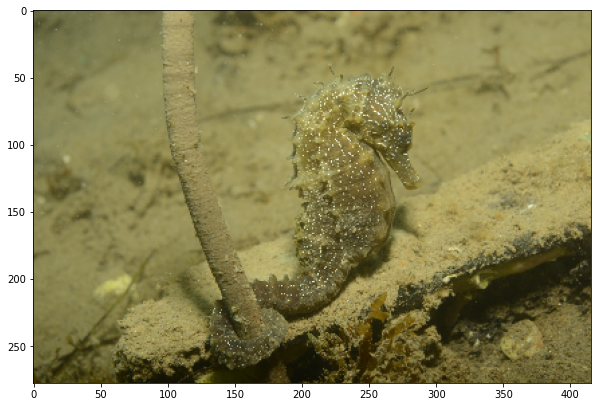

In [ ]:
pic = imageio.imread(PATH_TEST_IMAGE)
resize = iaa.Resize({"longer-side": CROP_SIZE, "shorter-side": "keep-aspect-ratio"})
pic = resize(image=pic)
plt.figure(num=0, figsize=(10,10))
plt.imshow(pic)
plt.show()

### $1.$ Particules (Salt)

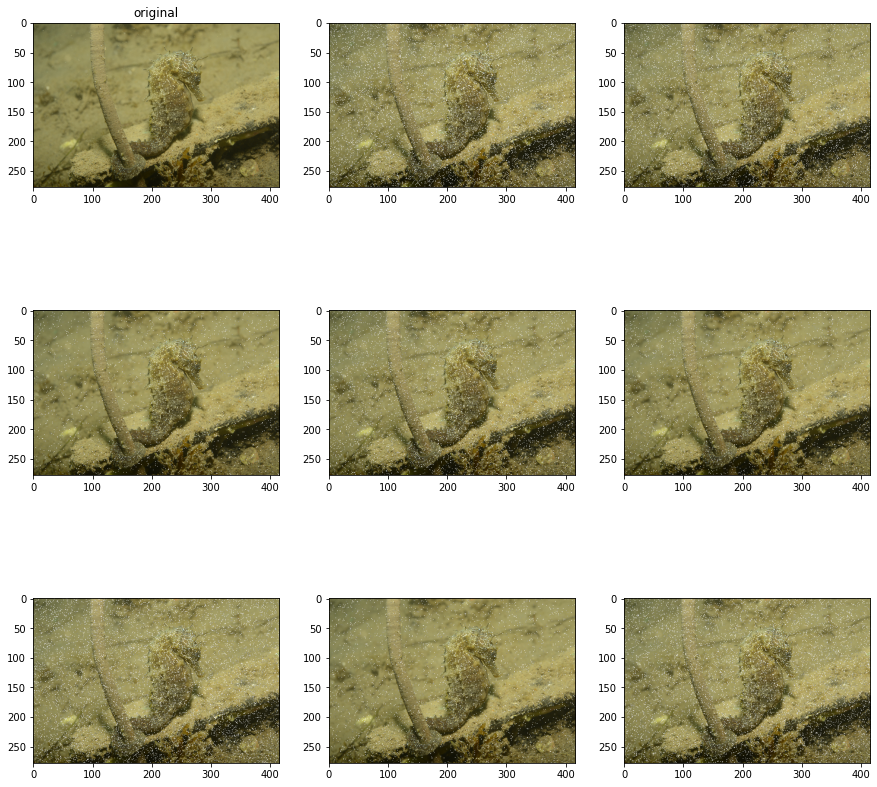

In [ ]:
salt = iaa.CoarseSalt((0.01, 0.1), size_px=(500,500))

plt.figure(num=1, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(salt(image=pic))
    
plt.show()

### $2.$ Rotations (Rotate)

#### Free

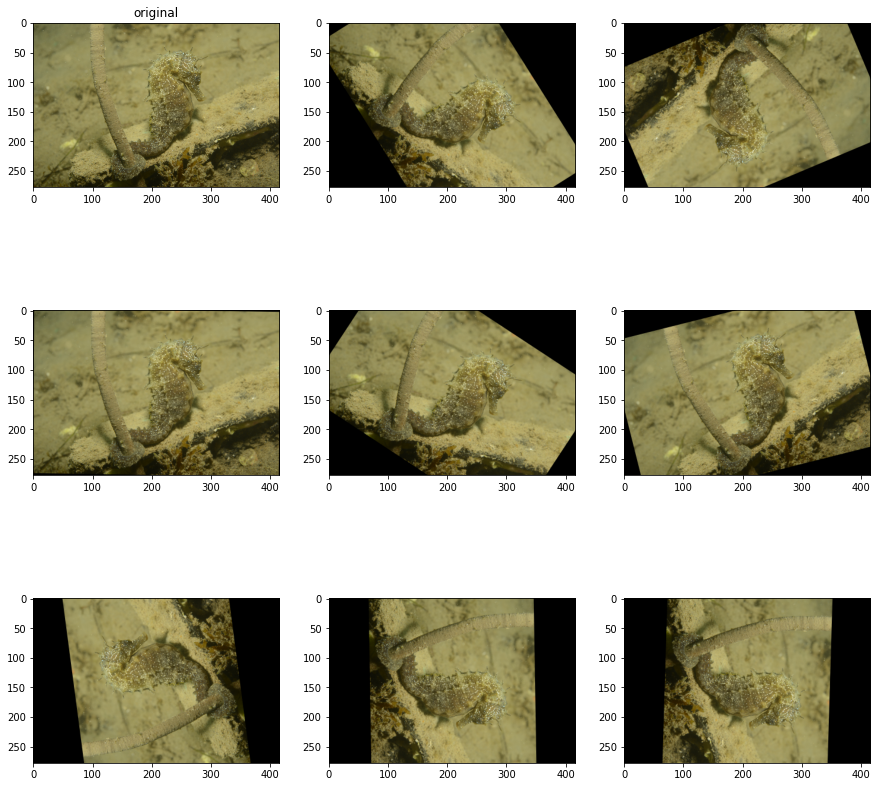

In [ ]:
rotate_free = iaa.Rotate((-180,180))

plt.figure(num=21, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(rotate_free(image=pic))
    
plt.show()

#### Fixed

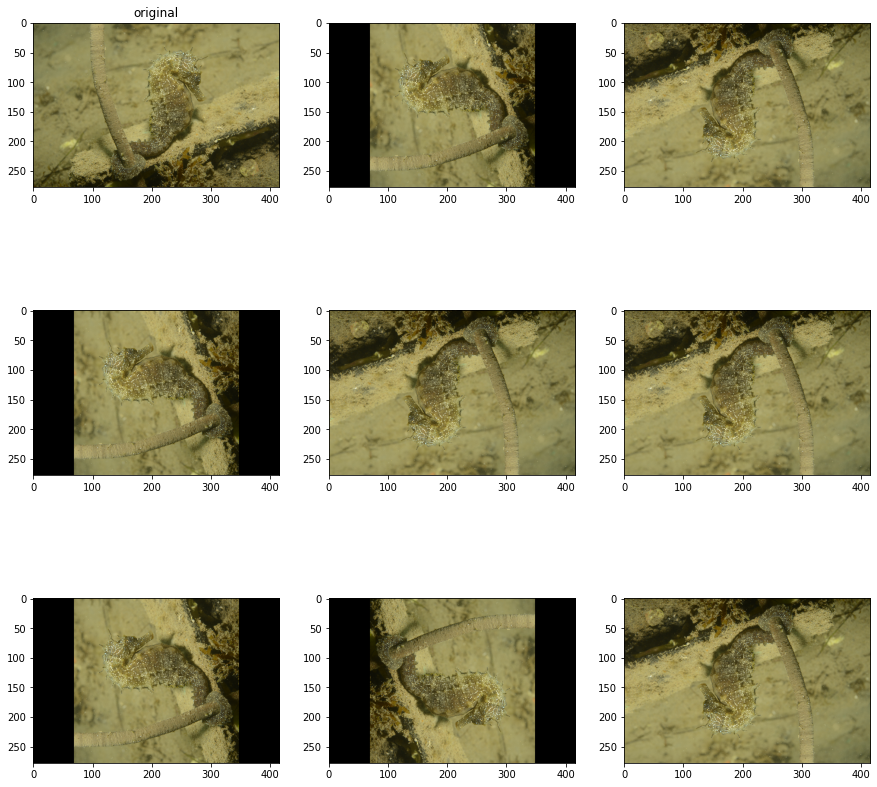

In [ ]:
rotate_fixed = iaa.Rotate([90, 180, -90])

plt.figure(num=22, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(rotate_fixed(image=pic))
    
plt.show()

### $3.$ Blur

#### GaussianBlur

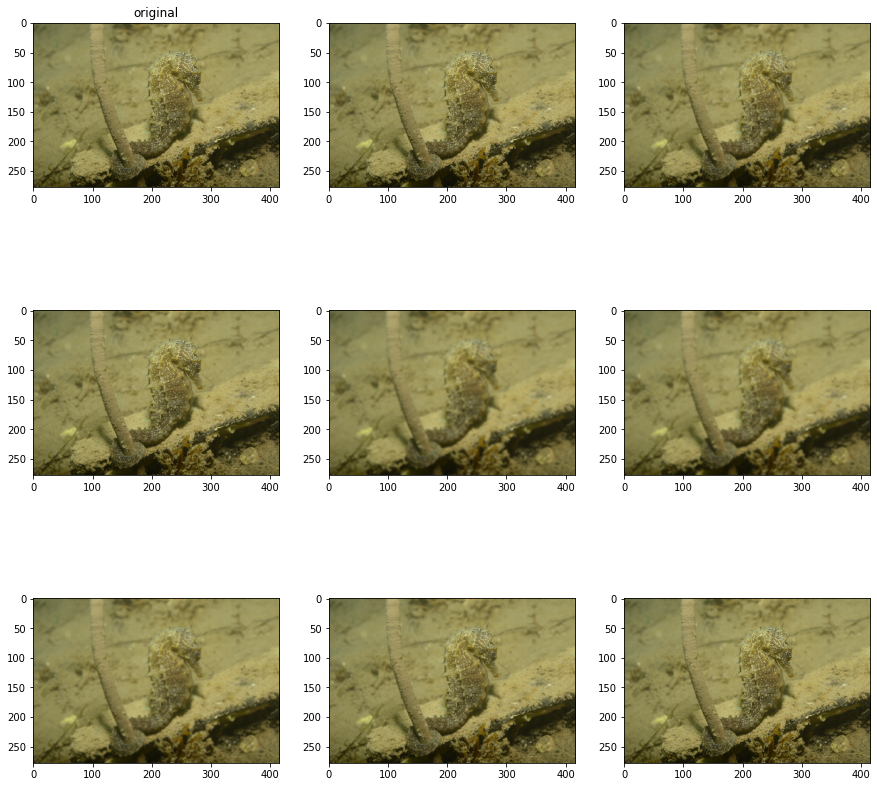

In [ ]:
blur_g = iaa.GaussianBlur(sigma=(0.0, 2.0))

plt.figure(num=31, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(blur_g(image=pic))
    
plt.show()

#### AverageBlur

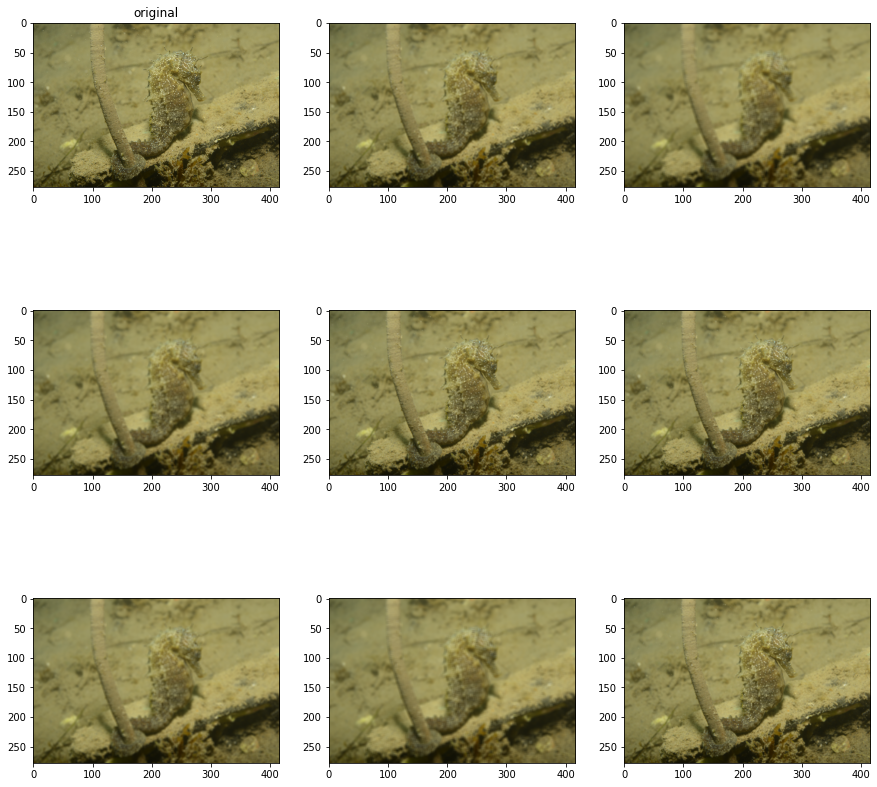

In [ ]:
blur_a = iaa.AverageBlur(k=(2,5))


plt.figure(num=32, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(blur_a(image=pic))
    
plt.show()

### $4.$ Flip (Flipud/Fliplr)

#### Flipud

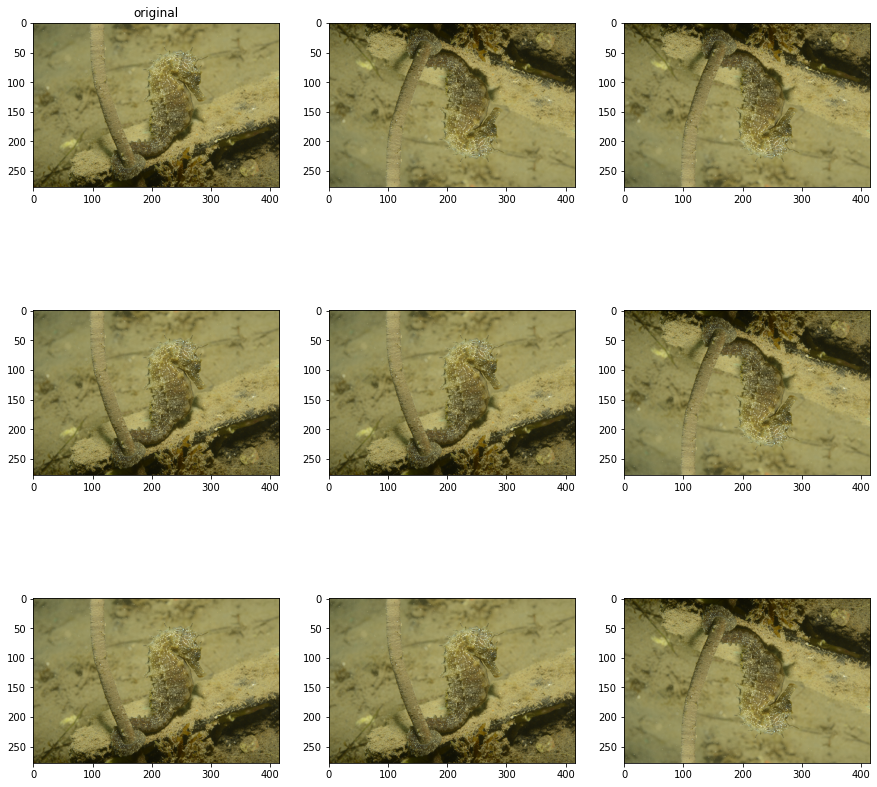

In [ ]:
flipud = iaa.Flipud(0.5)

plt.figure(num=41, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(flipud(image=pic))
    
plt.show()

#### Fliplr

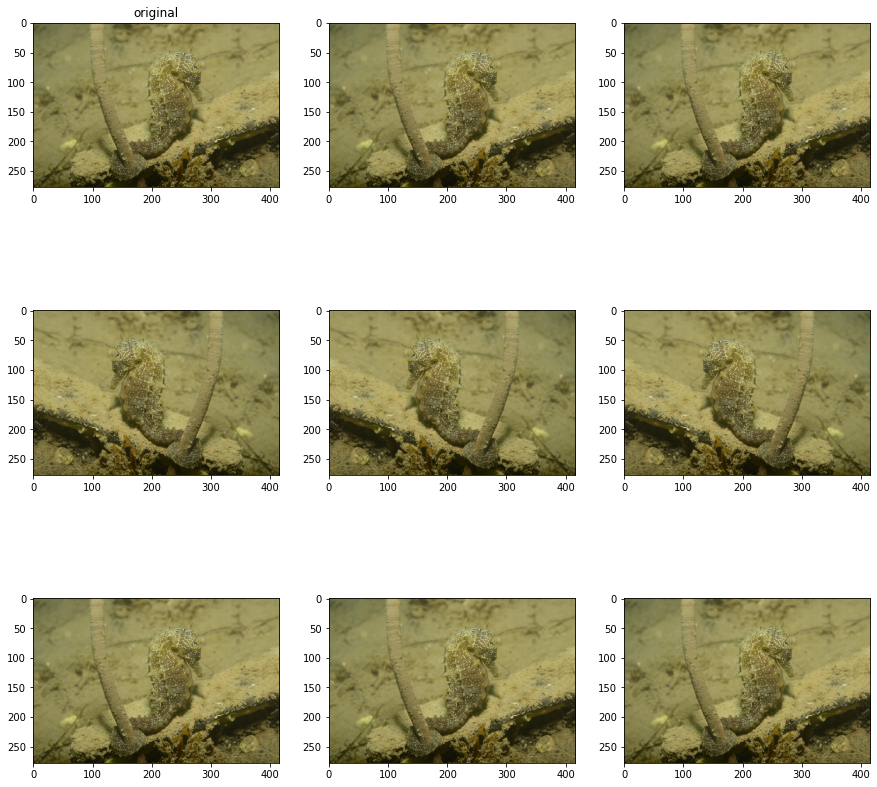

In [ ]:
fliplr = iaa.Fliplr(0.5)

plt.figure(num=42, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(fliplr(image=pic))
    
plt.show()

### $5.$ Coloration (ChangeColorTemperature)

In [ ]:
import numpy as np

class MyParameter(ia.parameters.StochasticParameter):
    
    def __init__(self, lb, ub, mid):
        self.lb = lb
        self.ub = ub
        self.mid = mid

    def _draw_samples(self, size, random_state):
        samples = []
        if np.random.random() < 0.5:
            samples.append(np.random.uniform(self.lb, self.mid))
        else:
            samples.append(np.random.uniform(self.mid, self.ub))
        return samples

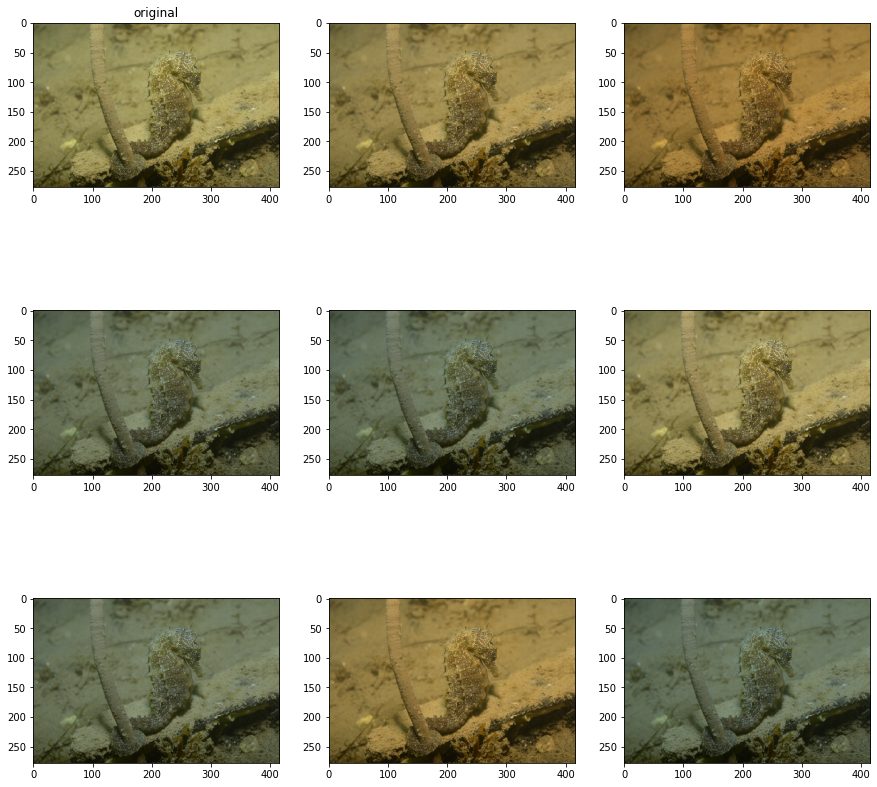

In [ ]:
color = iaa.ChangeColorTemperature(MyParameter(4000, 20000, 6600))

plt.figure(num=5, figsize=(i*5,j*5))
plt.subplot(j, i, 1)
plt.imshow(pic)
plt.title('original')

for id in range(2, nb_img+1):
    plt.subplot(j, i, id)
    plt.imshow(color(image=pic))
    
plt.show()

In [ ]:
assert(False)

AssertionError: 

## Exemple pour les Louisy

In [ ]:
import imageio
from matplotlib import pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
from config import *

In [ ]:
PATH = "D:/CEFE/Test/"

In [ ]:
resize = iaa.Resize({"longer-side": CROP_SIZE, "shorter-side": "keep-aspect-ratio"})
padding = iaa.PadToSquare(pad_mode="constant", pad_cval=0, position="left-bottom")

for folder in ["Bleu/", "Jaune/", "Flou/", "Particules/"]:
    for filename in ["img1.jpg", "img2.jpg", "img3.jpg"]:
        path = PATH + folder + filename
        pic = imageio.imread(path)
        pic = padding(image=resize(image=pic))
        imageio.imsave(path, pic)

In [ ]:
nb_values = 10
i, j = 1, 1
while i*j < nb_values+1:
    if i==j:
        j += 1
    else:
        i +=1

In [ ]:
# Bleu

test = False

folder = PATH + "Bleu/"

for filename in ["img1.jpg", "img2.jpg", "img3.jpg"]:
    
    img = imageio.imread(folder + filename)
    values = np.linspace(start=6600, stop=40000, num=nb_values)
    
    if test:
        plt.figure(figsize=(i*5,j*5))
        plt.subplot(j, i, 1)
        plt.imshow(img)
        plt.title('original')
    
    for id in range(nb_values):

        value = (int)(values[id])
        aug = iaa.ChangeColorTemperature(value)
        n_img = aug(image=img)
            
        if test:
            plt.subplot(j, i, id+2)
            plt.imshow(n_img)
            plt.title(value)
        else:
            plt.imsave(folder + filename.split(".")[0] + f"_{id+1}_{value}.jpg", n_img)
       
if test: 
    plt.show()

In [ ]:
# Jaune

test = False

folder = PATH + "Jaune/"

for filename in ["img1.jpg", "img2.jpg", "img3.jpg"]:
    
    img = imageio.imread(folder + filename)
    values = np.linspace(start=1000, stop=6600, num=nb_values)
    
    if test:
        plt.figure(figsize=(i*5,j*5))
        plt.subplot(j, i, 1)
        plt.imshow(img)
        plt.title('original')
    
    for id in range(nb_values):

        value = (int)(values[len(values)-id-1])
        aug = iaa.ChangeColorTemperature(value)
        n_img = aug(image=img)
            
        if test:
            plt.subplot(j, i, id+2)
            plt.imshow(n_img)
            plt.title(value)
        else:
            plt.imsave(folder + filename.split(".")[0] + f"_{id+1}_{value}.jpg", n_img)
       
if test: 
    plt.show()

In [ ]:
# Flou

test = False

folder = PATH + "Flou/"

for filename in ["img1.jpg", "img2.jpg", "img3.jpg"]:
    
    img = imageio.imread(folder + filename)
    values = range(3,13)
    
    if test:
        plt.figure(figsize=(i*5,j*5))
        plt.subplot(j, i, 1)
        plt.imshow(img)
        plt.title('original')
    
    for id in range(nb_values):

        value = values[id]
        aug = iaa.AverageBlur(k=value)
        n_img = aug(image=img)
            
        if test:
            plt.subplot(j, i, id+2)
            plt.imshow(n_img)
            plt.title(value)
        else:
            plt.imsave(folder + filename.split(".")[0] + f"_{id+1}_{value}.jpg", n_img)
       
if test: 
    plt.show()